# Studi Kasus 1 (Walkthrough)

<p> Pada kali ini Anda akan berperan sebagai seorang data engineer. Anda mendapatkan permintaan dari seorang *data analyst* dan *data scientist* untuk melakukan proses *data wrangling* pada sebuah dataset film untuk memastikan dataset tersebut siap dan layak untuk dianalisis oleh sang *data analyst* dan dapat menjadi basis pengembangan sebuah model prediktif yang sedang dikerjakan oleh sang *data scientist*</p>

<p>Dataset yang anda gunakan pada proyek ini berisi sejumlah daftar film beserta yang memuat informasi seperti:


*   Judul Film, Censorship Rating, Genre, Tahun Rilis, IMDb Score, Jumlah Vote IMDb,
*   Biaya Produksi (`budget`) dan Pemasukan Kotor (`gross`) yang dicetak masing-masing film
*   Flag yang merepresentasikan keterangan apakah film tersebut pernah dinominasikan/memenangkan kategori `*Best Picture*` pada *Academy Awards*.


Atas data tersebut, berikut detil informasi dan permintaan dari *data analyst*:
1.  Lakukan Penanganan Missing Values (Jika ada)
2.  Lakukan split atas kolom `released` sehingga didapatkan 2 kolom baru yakni `released_date` dan `released_country`. Lakukan penyesuaian format pada kolom `released_date` yang baru dibentuk sehingga memenuhi format **'yyyy-mm-dd'**
3.  Untuk setiap pemasukan kotor yang diperoleh masing-masing film, 50% di antaranya disetorkan ke Pihak Bioskop. Ini berarti Penghasilan yang diterima Pihak Studio hanya 50% dari total *gross*. Dengan informasi ini, hitunglah:
  * profit (50% gross - budget) yang dibukukan oleh masing-masing film.
  * Hitung pula profit yang telah disesuaikan berdasarkan tingkat inflasi pada tahun di mana masing-masing film tersebut dirilis!
4.   Kategorisasikan Profit (setelah disesuaikan dengan tingkat inflasi) ke dalam 5 kelas:
  * Rugi (Kurang dari 0)
  * 0 <= profit < 500,000
  * 500,000 <= profit < 1,000,000
  * 1,000,000 <= profit < 100,000,000
  * lebih dari 100,000,000

5.  Petakan kategori pada nomor 2 ke dalam list **[loss, low, medium, high, very high]**

Adapun permintaan dari *data scientist* adalah **lakukan transformasi atas seluruh *categorical attributes* yang ada ke dalam bentuk Encoding yang paling sesuai**




#0. Instalasi dan Import Library

In [286]:
!pip install -U pandera

In [287]:
!pip install missingno

In [288]:
import pandas as pd
import numpy as np
import pandera as pa
import missingno as msno
from tqdm import tqdm
import warnings, re

warnings.filterwarnings("ignore")

#1. Discovery and Preliminary Cleaning (Handling Missing Values)

In [289]:
df = pd.read_csv("1. movies.csv")
display(df.head())

print("Jumlah Record: ", len(df))

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,NaN,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,NaN,Twentieth Century Fox,115.0,NaN
1,Phobia,R,Drama,1980,"September 9, 1980 (United States)",4.0,NaN,John Huston,Gary Sherman,Paul Michael Glaser,Canada,5100000,NaN,Borough Park Productions,94.0,NaN
2,Cattle Annie and Little Britches,PG,Drama,1980,"April 24, 1981 (United States)",6.1,NaN,Lamont Johnson,David Eyre,Scott Glenn,United States,5100000,NaN,Cattle Annie Productions,97.0,NaN
3,The Last Flight of Noah's Ark,G,Adventure,1980,"June 25, 1980 (United States)",5.8,1300.0,Charles Jarrott,Ernest K. Gann,Elliott Gould,United States,6000000,NaN,Walt Disney Productions,97.0,NaN
4,Oh Heavenly Dog,PG,Comedy,1980,"July 11, 1980 (United States)",5.4,2400.0,Joe Camp,Rod Browning,Chevy Chase,United States,6000000,NaN,Mulberry Square Productions,103.0,NaN


Jumlah Record:  5436


In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436 entries, 0 to 5435
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5436 non-null   object 
 1   rating          5424 non-null   object 
 2   genre           5436 non-null   object 
 3   year            5436 non-null   int64  
 4   released        5436 non-null   object 
 5   score           5436 non-null   float64
 6   votes           5397 non-null   float64
 7   director        5436 non-null   object 
 8   writer          5436 non-null   object 
 9   star            5436 non-null   object 
 10  country         5435 non-null   object 
 11  budget          5436 non-null   int64  
 12  gross           5396 non-null   float64
 13  company         5434 non-null   object 
 14  runtime         5435 non-null   float64
 15  best_pic_award  208 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 679.6+ KB


##1.1 Check Missing Values

In [291]:
df.isna().sum()

name                 0
rating              12
genre                0
year                 0
released             0
score                0
votes               39
director             0
writer               0
star                 0
country              1
budget               0
gross               40
company              2
runtime              1
best_pic_award    5228
dtype: int64

<Axes: >

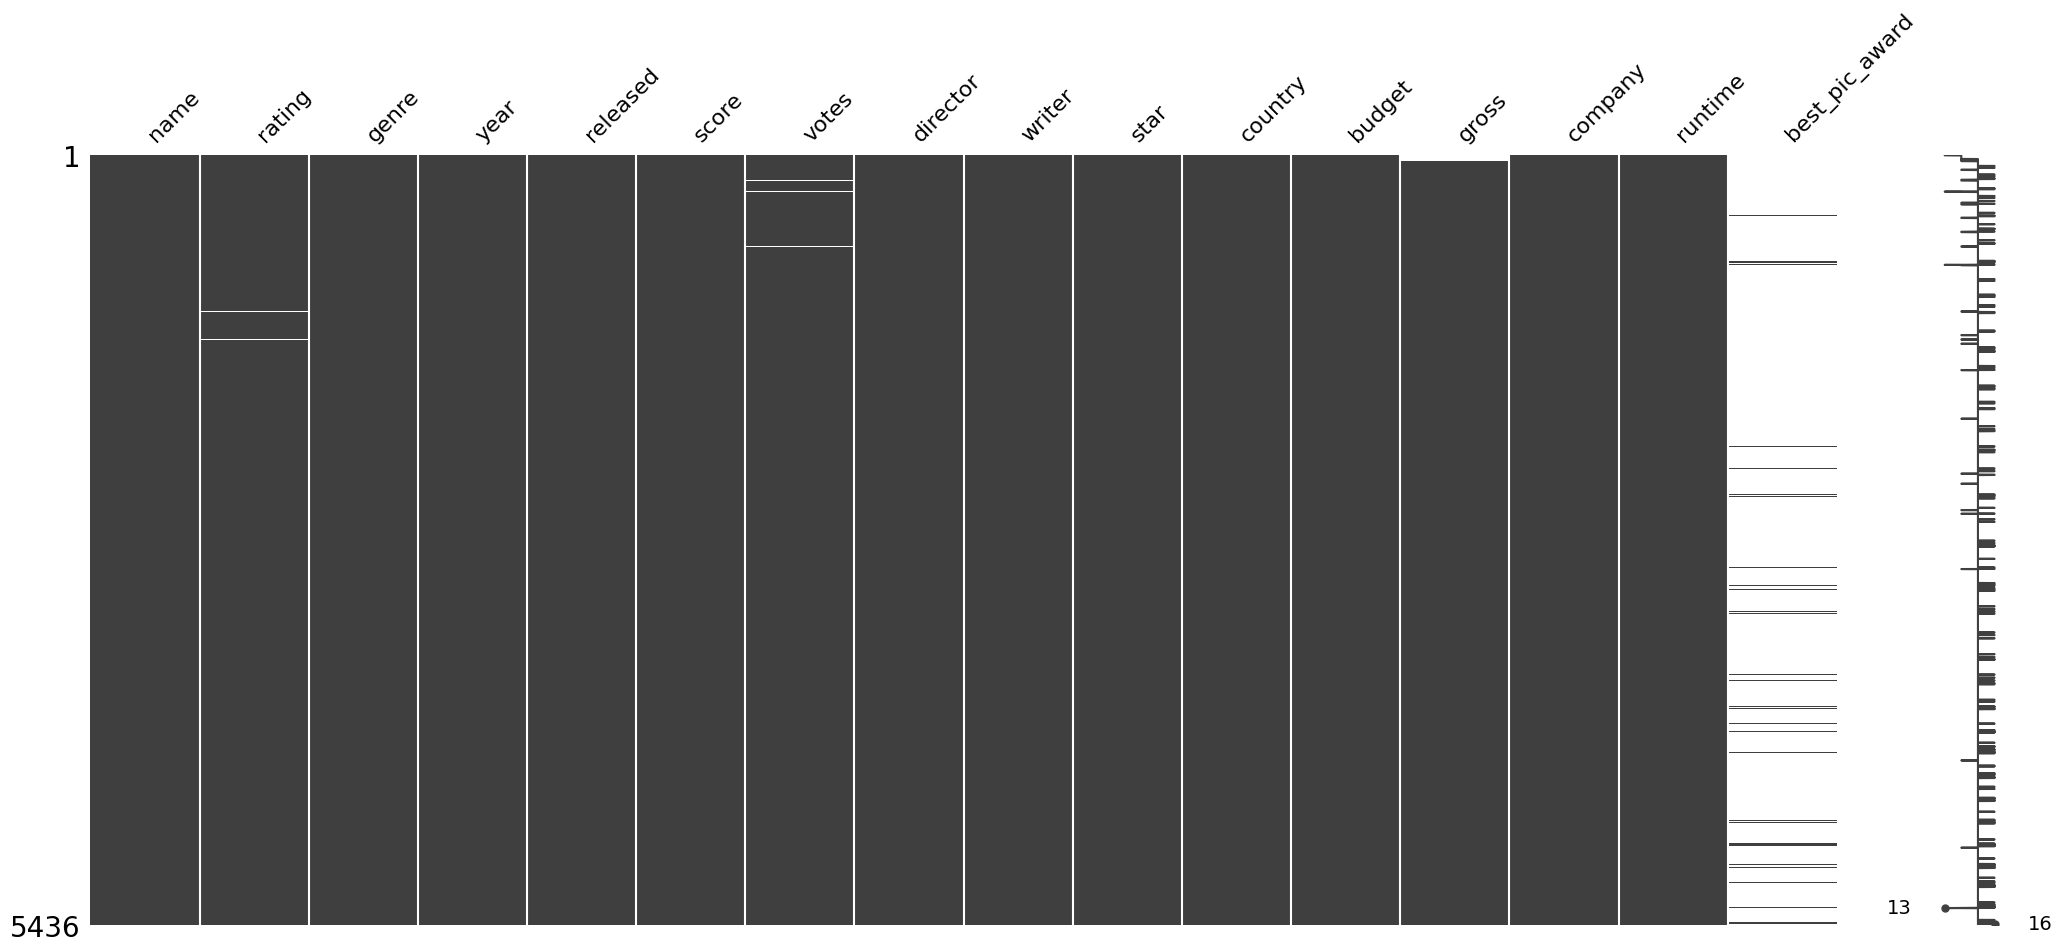

In [292]:
msno.matrix(df)

In [293]:
df  = df.sort_values(['year'], ascending=True)
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,NaN,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,NaN,Twentieth Century Fox,115.0,NaN
22,American Gigolo,R,Crime,1980,"February 1, 1980 (United States)",6.2,22000.0,Paul Schrader,Paul Schrader,Richard Gere,United States,4800000,NaN,Paramount Pictures,117.0,NaN
23,Private Benjamin,R,Comedy,1980,"October 10, 1980 (United States)",6.2,24000.0,Howard Zieff,Nancy Meyers,Goldie Hawn,United States,10000000,NaN,Warner Bros.,109.0,NaN
24,Somewhere in Time,PG,Drama,1980,"October 3, 1980 (United States)",7.2,27000.0,Jeannot Szwarc,Richard Matheson,Christopher Reeve,United States,5100000,NaN,Rastar Pictures,103.0,NaN
25,9 to 5,PG,Comedy,1980,"December 19, 1980 (United States)",6.9,29000.0,Colin Higgins,Patricia Resnick,Jane Fonda,United States,10000000,NaN,IPC Films,109.0,NaN


In [294]:
df.describe()

,year,score,votes,budget,gross,runtime
count,5436.000000,5436.000000,5.397000e+03,5.436000e+03,5.396000e+03,5435.000000
mean,2001.651582,6.392642,1.157367e+05,3.593864e+07,1.034397e+08,108.156394
std,10.541791,0.963200,1.846328e+05,4.154770e+07,1.875874e+08,18.121401
min,1980.000000,1.900000,1.000000e+03,6.000000e+03,3.090000e+02,63.000000
25%,1993.000000,5.800000,1.900000e+04,1.000000e+07,1.068520e+07,95.000000
50%,2002.000000,6.500000,5.300000e+04,2.100000e+07,3.696595e+07,105.000000
75%,2011.000000,7.100000,1.300000e+05,4.500000e+07,1.131464e+08,118.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,271.000000


In [295]:
df[df.gross.isna()].describe()

,year,score,votes,budget,gross,runtime
count,40.0,40.000000,3.700000e+01,4.000000e+01,0.0,40.000000
mean,1980.0,6.510000,1.025486e+05,1.156625e+07,NaN,111.125000
std,0.0,1.040414,2.450597e+05,1.090724e+07,NaN,22.501496
min,1980.0,4.000000,1.300000e+03,5.500000e+05,NaN,88.000000
25%,1980.0,5.875000,1.000000e+04,5.075000e+06,NaN,97.000000
50%,1980.0,6.600000,2.200000e+04,6.750000e+06,NaN,104.000000
75%,1980.0,7.200000,6.500000e+04,1.575000e+07,NaN,118.000000
max,1980.0,8.700000,1.200000e+06,5.400000e+07,NaN,219.000000


In [296]:
df.votes.describe()

count    5.397000e+03
mean     1.157367e+05
std      1.846328e+05
min      1.000000e+03
25%      1.900000e+04
50%      5.300000e+04
75%      1.300000e+05
max      2.400000e+06
Name: votes, dtype: float64

<Axes: >

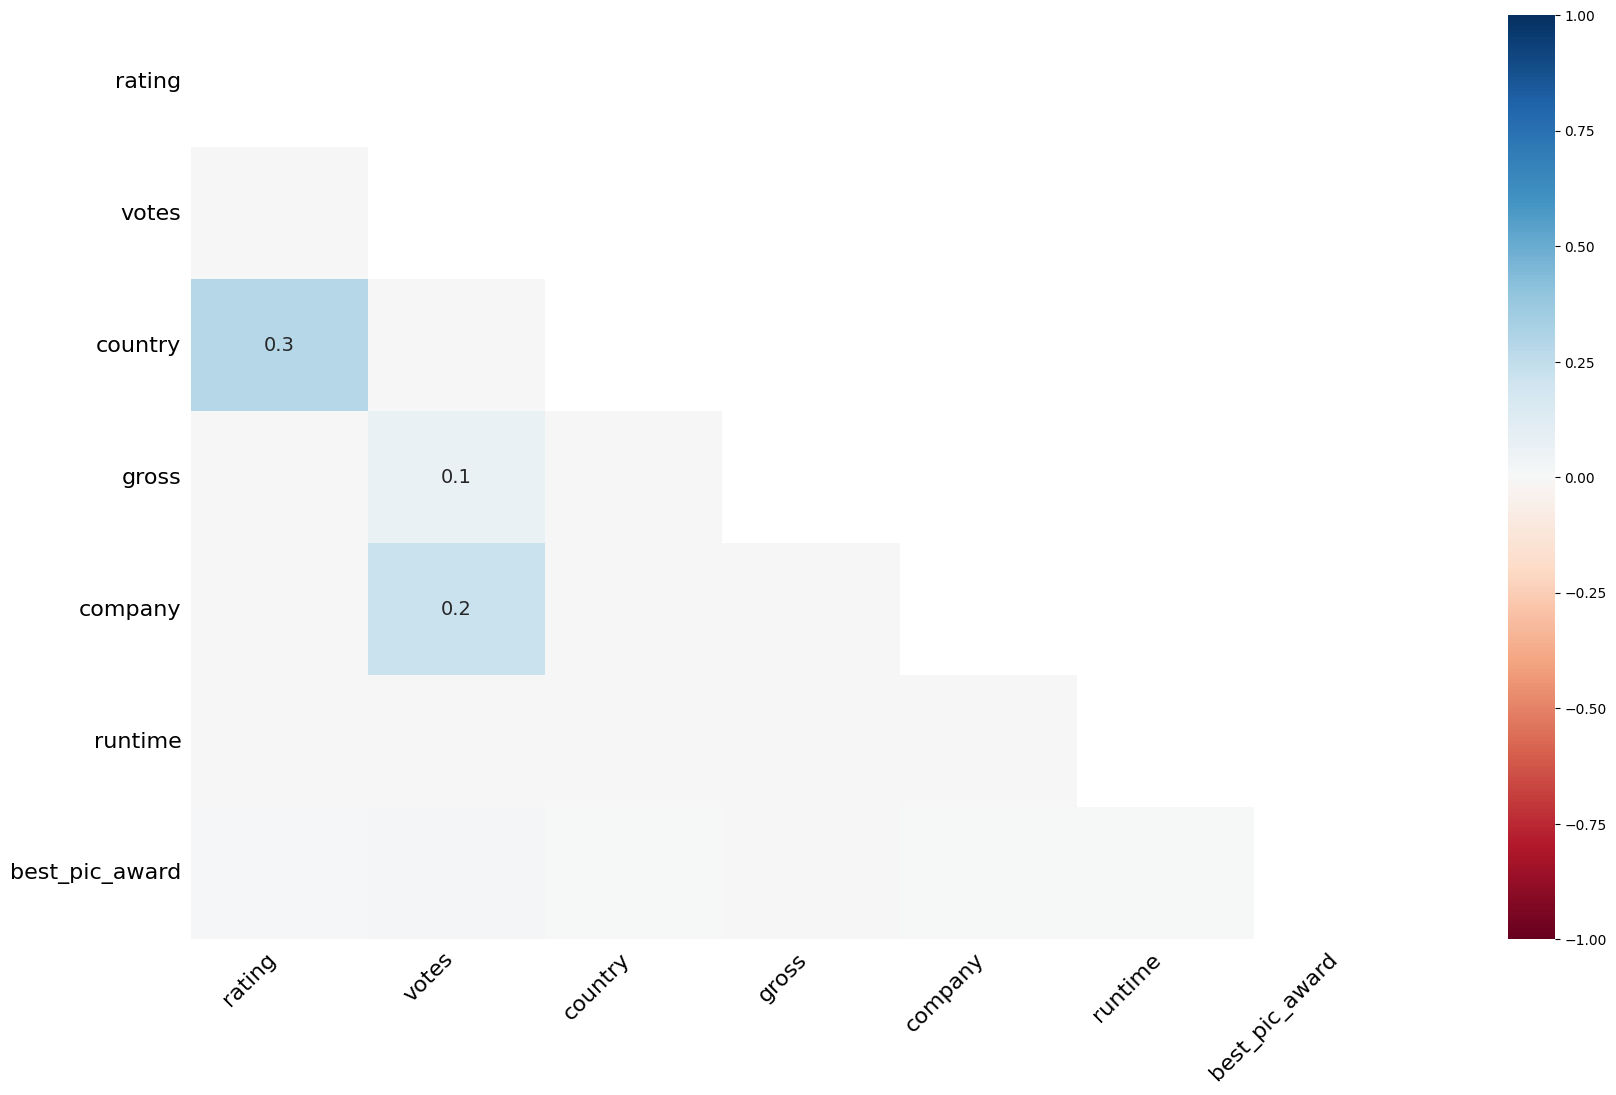

In [297]:
msno.heatmap(df)

Dari Hasil Identifikasi Missing Values didapatkan informasi sebagai berikut:

Kolom yang memiliki missing value

1. `rating`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Mode Imputation**
<br /><br />
2. `votes`
<br />Tipe atribut (Categorical/Numerik): **Numerik**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MNAR**
<br />Strategi: **Enrichment**
<br /><br />
3. `country`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Deletion**
<br /><br />
4. `gross`
<br />Tipe atribut (Categorical/Numerik): **Numerik**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MAR**
<br />Strategi: **Median Imputation**
<br /><br />
5. `company`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Deletion**
<br /><br />
6. `runtime`
<br />Tipe atribut (Categorical/Numerik): **Numerik**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Enrichment**
<br /><br />
5. `best_pic_award`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MAR**
<br />Strategi: **"Missing" Imputation**
<br /><br />

##1.2 Handling Missing Values

###1.2.1 Rating

In [298]:
# untuk atribut rating dengan missing values, kita akan mencari 2 genre tertinggi
display(df[df.rating.isna()]['genre'].value_counts().head(2).index)
print()

# temukan rating tertinggi untuk kedua genre tersebut
df[df.genre.isin(['Drama','Horror'])]['rating'].value_counts()

Index(['Drama', 'Horror'], dtype='object')

R            657
PG-13        335
PG            83
Not Rated     24
NC-17          7
Unrated        4
G              3
X              1
TV-MA          1
Name: rating, dtype: int64

In [299]:
df.rating.isna().sum()

12

In [300]:
# lakukan imputation dengan men-set nilai missing values pada kolom rating dengan rating tertinggi yang ditemukan sebelumnya
df.rating.fillna("R", inplace=True)

In [301]:
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes               39
director             0
writer               0
star                 0
country              1
budget               0
gross               40
company              2
runtime              1
best_pic_award    5228
dtype: int64

###1.2.2 Votes

In [302]:
# load data movies_votes yang digunakan pada votes enrichment

df_votes = pd.read_csv("1a. movies_votes.csv")
df_votes.columns = ["votes_"+col for col in list(df_votes.columns )]
df_votes.head()

,votes_name,votes_genre,votes_year,votes_score,votes_votes
0,High on the Hog,Action,2019,3.5,195
1,Getting It on,Comedy,1983,3.7,208
2,Almost You,Comedy,1984,5.1,216
3,Fever Pitch,Drama,1985,4.1,243
4,Sky Bandits,Action,1986,4.6,258


In [303]:
# lakukan join antara df dengan df_votes dengan menggunakan 3 atribut sebagai join key: judul film, tahun rilis, dan imdb score
df_merge = pd.merge(df, df_votes, how='left', left_on=['name','year','score'], right_on=['votes_name','votes_year','votes_score'])
checked_rows = list(df_merge[df_merge.votes.isna()].index)

votes_from_enrichment = df_merge.loc[df_merge.votes.isna(),'votes_votes']
votes_na = df_merge.votes.isna(), 'votes'

# proses imputation dengan menggunakan vote yang didapatkan dari prose enrichment
df_merge.loc[votes_na] = votes_from_enrichment
df_merge.loc[checked_rows]

,name,rating,genre,year,released,score,votes,director,writer,star,...,budget,gross,company,runtime,best_pic_award,votes_name,votes_genre,votes_year,votes_score,votes_votes
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,415.0,Paul Mazursky,Jean Gruault,Michael Ontkean,...,5500000,NaN,Twentieth Century Fox,115.0,NaN,Willie & Phil,Comedy,1980.0,5.9,415.0
23,Phobia,R,Drama,1980,"September 9, 1980 (United States)",4.0,546.0,John Huston,Gary Sherman,Paul Michael Glaser,...,5100000,NaN,Borough Park Productions,94.0,NaN,Phobia,Drama,1980.0,4.0,546.0
24,Cattle Annie and Little Britches,PG,Drama,1980,"April 24, 1981 (United States)",6.1,604.0,Lamont Johnson,David Eyre,Scott Glenn,...,5100000,NaN,Cattle Annie Productions,97.0,NaN,Cattle Annie and Little Britches,Drama,1980.0,6.1,604.0
74,King of the Mountain,PG,Action,1981,"May 1, 1981 (United States)",5.5,384.0,Noel Nosseck,David Barry,Harry Hamlin,...,2000000,1791147.0,PolyGram Pictures,90.0,NaN,King of the Mountain,Action,1981.0,5.5,384.0
75,Inchon,PG,Drama,1981,"September 17, 1982 (United States)",2.7,659.0,Terence Young,Robin Moore,Laurence Olivier,...,46000000,5200986.0,One Way Productions,140.0,NaN,Inchon,Drama,1981.0,2.7,659.0
76,Take This Job and Shove It,PG,Comedy,1981,"May 15, 1981 (United States)",5.0,761.0,Gus Trikonis,Barry Schneider,Robert Hays,...,3500000,17569027.0,Cinema Group Ventures,100.0,NaN,Take This Job and Shove It,Comedy,1981.0,5.0,761.0
77,Honky Tonk Freeway,PG,Action,1981,"August 21, 1981 (United States)",5.2,928.0,John Schlesinger,Edward Clinton,David Rasche,...,24000000,2004742.0,EMI Films,107.0,NaN,Honky Tonk Freeway,Action,1981.0,5.2,928.0
150,Jinxed!,R,Comedy,1982,"October 22, 1982 (United States)",4.7,984.0,Don Siegel,Frank D. Gilroy,Bette Midler,...,13400000,2869638.0,Herb Jaffe,103.0,NaN,Jinxed!,Comedy,1982.0,4.7,984.0
151,Lookin' to Get Out,R,Comedy,1982,"June 30, 1983 (Australia)",5.1,684.0,Hal Ashby,Al Schwartz,Jon Voight,...,17000000,946461.0,Lorimar Productions,105.0,NaN,Lookin' to Get Out,Comedy,1982.0,5.1,684.0
152,"Yes, Giorgio",PG,Comedy,1982,"September 24, 1982 (United States)",3.9,653.0,Franklin J. Schaffner,Anne Piper,Luciano Pavarotti,...,19000000,2279543.0,Metro-Goldwyn-Mayer (MGM),110.0,NaN,"Yes, Giorgio",Comedy,1982.0,3.9,653.0


In [304]:
# drop seluruh kolom hasil enrichment pasca imputasi
df = df_merge[list(df.columns)]
display(df.head())
print("Number of records: ", len(df))
df.isna().sum()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,415.0,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,NaN,Twentieth Century Fox,115.0,NaN
1,American Gigolo,R,Crime,1980,"February 1, 1980 (United States)",6.2,22000.0,Paul Schrader,Paul Schrader,Richard Gere,United States,4800000,NaN,Paramount Pictures,117.0,NaN
2,Private Benjamin,R,Comedy,1980,"October 10, 1980 (United States)",6.2,24000.0,Howard Zieff,Nancy Meyers,Goldie Hawn,United States,10000000,NaN,Warner Bros.,109.0,NaN
3,Somewhere in Time,PG,Drama,1980,"October 3, 1980 (United States)",7.2,27000.0,Jeannot Szwarc,Richard Matheson,Christopher Reeve,United States,5100000,NaN,Rastar Pictures,103.0,NaN
4,9 to 5,PG,Comedy,1980,"December 19, 1980 (United States)",6.9,29000.0,Colin Higgins,Patricia Resnick,Jane Fonda,United States,10000000,NaN,IPC Films,109.0,NaN


Number of records:  5436


name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes                0
director             0
writer               0
star                 0
country              1
budget               0
gross               40
company              2
runtime              1
best_pic_award    5228
dtype: int64

###1.2.3. Country

In [305]:
df[df['country'].isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
5396,Clinton Road,R,Horror,2019,"June 14, 2019 (United States)",5.9,1900.0,Richard Grieco,Noel Ashman,Ace Young,NaN,2500000,50400.0,Growing Tree Productions,77.0,NaN


In [306]:
#lakukan deletion pada kolom country

df.dropna(subset=['country'], inplace=True)
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes                0
director             0
writer               0
star                 0
country              0
budget               0
gross               40
company              2
runtime              1
best_pic_award    5227
dtype: int64

###1.2.4 Runtime

In [307]:
df[df['runtime'].isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
4334,One for the Money,PG-13,Action,2012,"January 27, 2012 (United States)",5.3,41000.0,Julie Anne Robinson,Stacy Sherman,Katherine Heigl,United States,40000000,38084162.0,Lakeshore Entertainment,NaN,NaN


In [308]:
# sedikit googling akan memberikan informasi runtime atas film tersebut yakni: 91 menit
df['runtime'].fillna(91, inplace=True)
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes                0
director             0
writer               0
star                 0
country              0
budget               0
gross               40
company              2
runtime              0
best_pic_award    5227
dtype: int64

###1.2.5 Company

In [309]:
df[df.company.isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
319,The Bear,PG,Biography,1984,"September 28, 1984 (United States)",6.1,270.0,Richard C. Sarafian,Michael Kane,Gary Busey,United States,221000,2687148.0,NaN,110.0,NaN
858,Heart of Dixie,PG,Drama,1989,"August 25, 1989 (United States)",5.2,677.0,Martin Davidson,Anne Rivers Siddons,Ally Sheedy,United States,8000000,1097333.0,NaN,95.0,NaN


In [310]:
#lakukan proses deletion pada atribut company

df.dropna(subset=['company'], inplace=True)
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes                0
director             0
writer               0
star                 0
country              0
budget               0
gross               40
company              0
runtime              0
best_pic_award    5225
dtype: int64

###1.2.6 Gross

In [311]:
# berikut adalah daftar genre dari setiap record dengan missing values pada atribut gross
missing_genres = list(df[df['gross'].isna()].groupby(['genre'])['name'].count().index)
missing_genres

['Action',
 'Adventure',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Fantasy',
 'Horror']

In [312]:
# Asumsi: seluruh missing values akan di-impute dengan menggunakan median untuk masing-masing genre pada 1981
for genre in missing_genres:
  rows_to_impute = (df['genre'] == genre) & (df['gross'].isna())
  median = df[(df['genre'] == genre) & (df['year'] == 1981)].median()['gross']
  checked_rows = list(df.loc[rows_to_impute, :].index)

  print(f"genre: {genre}")
  print(f"median: {median}")

  df.loc[rows_to_impute, 'gross'] = median
  display(df.loc[checked_rows, 'gross'])

genre: Action
median: 19905359.0


11    19905359.0
17    19905359.0
19    19905359.0
20    19905359.0
21    19905359.0
26    19905359.0
27    19905359.0
28    19905359.0
31    19905359.0
32    19905359.0
34    19905359.0
Name: gross, dtype: float64

genre: Adventure
median: 27966875.5


5     27966875.5
8     27966875.5
9     27966875.5
30    27966875.5
37    27966875.5
Name: gross, dtype: float64

genre: Biography
median: 40382659.0


15    40382659.0
33    40382659.0
Name: gross, dtype: float64

genre: Comedy
median: 26154211.0


0     26154211.0
2     26154211.0
4     26154211.0
12    26154211.0
14    26154211.0
18    26154211.0
25    26154211.0
29    26154211.0
35    26154211.0
38    26154211.0
Name: gross, dtype: float64

genre: Crime
median: 10062128.5


1     10062128.5
6     10062128.5
22    10062128.5
39    10062128.5
Name: gross, dtype: float64

genre: Drama
median: 10011275.0


3     10011275.0
7     10011275.0
16    10011275.0
23    10011275.0
24    10011275.0
Name: gross, dtype: float64

genre: Fantasy
median: nan


36   NaN
Name: gross, dtype: float64

genre: Horror
median: 10626725.0


10    10626725.0
13    10626725.0
Name: gross, dtype: float64

In [313]:
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes                0
director             0
writer               0
star                 0
country              0
budget               0
gross                1
company              0
runtime              0
best_pic_award    5225
dtype: int64

In [314]:
# setelah ditelisik ternyata masih terdapat 1 missing value pada atribut gross. Hal ini disebabkan pada proses imputasi sebelumnya,
# record tersebut tidak berhasil diupdate karena pada tahun 1981 tidak terdapat record dengan genre Fantasy.
df[df['genre'] == 'Fantasy'].year.value_counts().sort_index()

1988    4
1987    3
2019    2
1993    2
1999    2
2007    2
1997    2
1995    2
1992    2
1989    2
1985    2
2001    2
2006    1
2011    1
2010    1
2013    1
2008    1
2018    1
1980    1
2003    1
1998    1
1982    1
1994    1
1991    1
1990    1
1983    1
1996    1
Name: year, dtype: int64

In [315]:
# karena jumlah film pada genre Fantasy terbatas, maka proses imputasi akan menggunakan median dari gross film Fantasy pada rentang waktu 1981-1989
condition = (df['genre'] == 'Fantasy') & (df['year'].isin(list(range(1981,1990))))
fantasy_median = df[condition]['gross'].median()
df.loc[(df['genre'] == 'Fantasy') & (df['gross'].isna()), 'gross'] = fantasy_median
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
released             0
score                0
votes                0
director             0
writer               0
star                 0
country              0
budget               0
gross                0
company              0
runtime              0
best_pic_award    5225
dtype: int64

###1.2.7 Best Picture Award

In [316]:
df.best_pic_award.value_counts()

nominated    171
winner        37
Name: best_pic_award, dtype: int64

In [317]:
df.best_pic_award.isna().sum()

5225

In [318]:
# lakukan "missing imputation" untuk atribut best_pic_award
df.best_pic_award.fillna("none", inplace=True)
df.best_pic_award.value_counts()

none         5225
nominated     171
winner         37
Name: best_pic_award, dtype: int64

In [319]:
df.isna().sum()

name              0
rating            0
genre             0
year              0
released          0
score             0
votes             0
director          0
writer            0
star              0
country           0
budget            0
gross             0
company           0
runtime           0
best_pic_award    0
dtype: int64

#2. Further Cleaning and Enrichment

##2.1 Split kolom `released` menjadi kolom `released_date` dan kolom `released_country`

In [320]:
from datetime import datetime
def clean_date(d, format="%Y-%m-%d"):
  try:
    d = re.findall("[\w]+\s[\d]+,\s\d{4}", d)[0]
    return datetime.strftime(datetime.strptime(d, "%B %d, %Y"), format)
  except:
    return d

def get_released_country(d):
  try:
    return re.findall("\((.*?)\)", string)[0]
  except:
    return d

# sanity check
string =  "December 18, 1989 (United States)"
print(clean_date(string))
print(get_released_country(string))


1989-12-18
United States


In [321]:
# lakukan cleansing dengan menggunakan kedua fungsi di atas berdasarkan nilai dari kolom `released`
df['released_date'] = df.released.apply(clean_date)
df['released_country'] = df.released.apply(get_released_country)
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award,released_date,released_country
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,415.0,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,26154211.0,Twentieth Century Fox,115.0,none,1980-08-15,United States
1,American Gigolo,R,Crime,1980,"February 1, 1980 (United States)",6.2,22000.0,Paul Schrader,Paul Schrader,Richard Gere,United States,4800000,10062128.5,Paramount Pictures,117.0,none,1980-02-01,United States
2,Private Benjamin,R,Comedy,1980,"October 10, 1980 (United States)",6.2,24000.0,Howard Zieff,Nancy Meyers,Goldie Hawn,United States,10000000,26154211.0,Warner Bros.,109.0,none,1980-10-10,United States
3,Somewhere in Time,PG,Drama,1980,"October 3, 1980 (United States)",7.2,27000.0,Jeannot Szwarc,Richard Matheson,Christopher Reeve,United States,5100000,10011275.0,Rastar Pictures,103.0,none,1980-10-03,United States
4,9 to 5,PG,Comedy,1980,"December 19, 1980 (United States)",6.9,29000.0,Colin Higgins,Patricia Resnick,Jane Fonda,United States,10000000,26154211.0,IPC Films,109.0,none,1980-12-19,United States


##2.2. Hitung Profit

###2.2.1 Hitung *Unadjusted Gross* (50% dari gross yang belum disesuaikan dengan inflasi)

In [322]:
df['unadjusted_gross'] = df['gross'] * 0.5
df[['gross','unadjusted_gross']].head()

,gross,unadjusted_gross
0,26154211.0,13077105.50
1,10062128.5,5031064.25
2,26154211.0,13077105.50
3,10011275.0,5005637.50
4,26154211.0,13077105.50


###2.2.2 Hitung *Unadjusted Profit* (`unadjusted_gross` - `budget`, belum disesuaikan dengan inflasi)

In [323]:
df['unadjusted_profit'] = df['unadjusted_gross'] - df['budget']
df[['name','year','budget','gross','unadjusted_gross','unadjusted_profit']].sample(5)

,name,year,budget,gross,unadjusted_gross,unadjusted_profit
2058,Major League: Back to the Minors,1998,18000000,3572443.0,1786221.5,-16213778.5
1156,A Few Good Men,1992,41000000,243240178.0,121620089.0,80620089.0
148,Jekyll and Hyde... Together Again,1982,5000000,3792188.0,1896094.0,-3103906.0
3610,The Chronicles of Narnia: Prince Caspian,2008,225000000,419665568.0,209832784.0,-15167216.0
369,Back to the Future,1985,19000000,381906762.0,190953381.0,171953381.0


###2.2.3 Hitung Adjusted Profit menggunakan Data Inflasi (*enrichment*)

In [324]:
df_inflation = pd.read_csv("1b. inflation.csv")
df_inflation

,year,present_equivalent_value
0,1956,11.32
1,1957,10.96
2,1958,10.66
3,1959,10.56
4,1960,10.41
...,...,...
62,2018,1.23
63,2019,1.20
64,2020,1.19
65,2021,1.14


In [325]:
#proses enrichment dengan menggunakan df_inflasion berdasarkan tahun rilis sebagai join key
df = pd.merge(df, df_inflation, how='left', left_on='year', right_on='year')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,...,budget,gross,company,runtime,best_pic_award,released_date,released_country,unadjusted_gross,unadjusted_profit,present_equivalent_value
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,415.0,Paul Mazursky,Jean Gruault,Michael Ontkean,...,5500000,26154211.0,Twentieth Century Fox,115.0,none,1980-08-15,United States,13077105.50,7577105.50,3.73
1,American Gigolo,R,Crime,1980,"February 1, 1980 (United States)",6.2,22000.0,Paul Schrader,Paul Schrader,Richard Gere,...,4800000,10062128.5,Paramount Pictures,117.0,none,1980-02-01,United States,5031064.25,231064.25,3.73
2,Private Benjamin,R,Comedy,1980,"October 10, 1980 (United States)",6.2,24000.0,Howard Zieff,Nancy Meyers,Goldie Hawn,...,10000000,26154211.0,Warner Bros.,109.0,none,1980-10-10,United States,13077105.50,3077105.50,3.73
3,Somewhere in Time,PG,Drama,1980,"October 3, 1980 (United States)",7.2,27000.0,Jeannot Szwarc,Richard Matheson,Christopher Reeve,...,5100000,10011275.0,Rastar Pictures,103.0,none,1980-10-03,United States,5005637.50,-94362.50,3.73
4,9 to 5,PG,Comedy,1980,"December 19, 1980 (United States)",6.9,29000.0,Colin Higgins,Patricia Resnick,Jane Fonda,...,10000000,26154211.0,IPC Films,109.0,none,1980-12-19,United States,13077105.50,3077105.50,3.73


In [326]:
df['adjusted_profit'] = df['unadjusted_profit'] * df['present_equivalent_value']
df[['name','year','budget','gross','unadjusted_gross','unadjusted_profit', 'present_equivalent_value','adjusted_profit']].sample(5)

,name,year,budget,gross,unadjusted_gross,unadjusted_profit,present_equivalent_value,adjusted_profit
5276,Ophelia,2018,12000000,242115.0,121057.5,-11878942.5,1.23,-1.461110e+07
5091,Alien: Covenant,2017,97000000,240891763.0,120445881.5,23445881.5,1.26,2.954181e+07
4892,Independence Day: Resurgence,2016,165000000,389681935.0,194840967.5,29840967.5,1.28,3.819644e+07
245,Spacehunter: Adventures in the Forbidden Zone,1983,14400000,16478265.0,8239132.5,-6160867.5,3.09,-1.903708e+07
5168,Rough Night,2017,20000000,47347283.0,23673641.5,3673641.5,1.26,4.628788e+06


###2.2.4 Kategorisasi Profit

In [327]:
df['adjusted_profit'].describe()

count    5.433000e+03
mean     2.290384e+07
std      1.062095e+08
min     -2.389285e+08
25%     -2.146187e+07
50%     -1.804067e+06
75%      2.922670e+07
max      1.729581e+09
Name: adjusted_profit, dtype: float64

In [328]:
# lakukan kategorisasi adjusted profit berdasarkan bracket/bins yang tertera pada deskripsi di awal project ini.
# labels=['loss', 'low_profit', 'medium_profit', 'high_profit', 'very_high_profit']

df['profit_class'] = pd.cut(df['adjusted_profit'],
       bins=[-np.inf, 0, 500000, 1000000, 100000000, np.inf],
       labels = ['loss', 'low_profit', 'medium_profit', 'high_profit', 'very_high_profit'],
       include_lowest=True)
df[['name','adjusted_profit','profit_class']]

,name,adjusted_profit,profit_class
0,Willie & Phil,2.826260e+07,high_profit
1,American Gigolo,8.618697e+05,medium_profit
2,Private Benjamin,1.147760e+07,high_profit
3,Somewhere in Time,-3.519721e+05,loss
4,9 to 5,1.147760e+07,high_profit
...,...,...,...
5428,Dolittle,-6.218479e+07,loss
5429,Sonic the Hedgehog,8.908083e+07,high_profit
5430,Bad Boys for Life,1.466706e+08,very_high_profit
5431,The Invisible Man,7.684484e+07,high_profit


In [329]:
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,...,company,runtime,best_pic_award,released_date,released_country,unadjusted_gross,unadjusted_profit,present_equivalent_value,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,415.0,Paul Mazursky,Jean Gruault,Michael Ontkean,...,Twentieth Century Fox,115.0,none,1980-08-15,United States,13077105.50,7577105.50,3.73,2.826260e+07,high_profit
1,American Gigolo,R,Crime,1980,"February 1, 1980 (United States)",6.2,22000.0,Paul Schrader,Paul Schrader,Richard Gere,...,Paramount Pictures,117.0,none,1980-02-01,United States,5031064.25,231064.25,3.73,8.618697e+05,medium_profit
2,Private Benjamin,R,Comedy,1980,"October 10, 1980 (United States)",6.2,24000.0,Howard Zieff,Nancy Meyers,Goldie Hawn,...,Warner Bros.,109.0,none,1980-10-10,United States,13077105.50,3077105.50,3.73,1.147760e+07,high_profit
3,Somewhere in Time,PG,Drama,1980,"October 3, 1980 (United States)",7.2,27000.0,Jeannot Szwarc,Richard Matheson,Christopher Reeve,...,Rastar Pictures,103.0,none,1980-10-03,United States,5005637.50,-94362.50,3.73,-3.519721e+05,loss
4,9 to 5,PG,Comedy,1980,"December 19, 1980 (United States)",6.9,29000.0,Colin Higgins,Patricia Resnick,Jane Fonda,...,IPC Films,109.0,none,1980-12-19,United States,13077105.50,3077105.50,3.73,1.147760e+07,high_profit


In [330]:
df[df['profit_class'].isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,...,company,runtime,best_pic_award,released_date,released_country,unadjusted_gross,unadjusted_profit,present_equivalent_value,adjusted_profit,profit_class


In [331]:
selected_cols = ['name','rating','genre','year','released_date','score',
                 'director','budget','unadjusted_gross','unadjusted_profit','adjusted_profit','profit_class']
df = df[selected_cols]
df.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,high_profit
1,American Gigolo,R,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,8.618697e+05,medium_profit
2,Private Benjamin,R,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,1.147760e+07,high_profit
3,Somewhere in Time,PG,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,-3.519721e+05,loss
4,9 to 5,PG,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,1.147760e+07,high_profit


#3. Verifying

In [332]:
len(df)

5433

In [333]:
schema = pa.DataFrameSchema(
    {
        "year": pa.Column(int, pa.Check.isin(list(range(1980,2023)))),
        "budget": pa.Column(int, pa.Check.greater_than(0))
    }
)
schema.validate(df)

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,1.307711e+07,7.577106e+06,2.826260e+07,high_profit
1,American Gigolo,R,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5.031064e+06,2.310642e+05,8.618697e+05,medium_profit
2,Private Benjamin,R,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,1.307711e+07,3.077106e+06,1.147760e+07,high_profit
3,Somewhere in Time,PG,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5.005638e+06,-9.436250e+04,-3.519721e+05,loss
4,9 to 5,PG,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,1.307711e+07,3.077106e+06,1.147760e+07,high_profit
...,...,...,...,...,...,...,...,...,...,...,...,...
5428,Dolittle,PG,Adventure,2020,2020-01-17,5.6,Stephen Gaghan,175000000,1.227439e+08,-5.225612e+07,-6.218479e+07,loss
5429,Sonic the Hedgehog,PG,Action,2020,2020-02-14,6.5,Jeff Fowler,85000000,1.598578e+08,7.485784e+07,8.908083e+07,high_profit
5430,Bad Boys for Life,R,Action,2020,2020-01-17,6.6,Adil El Arbi,90000000,2.132526e+08,1.232526e+08,1.466706e+08,very_high_profit
5431,The Invisible Man,R,Drama,2020,2020-02-28,7.1,Leigh Whannell,7000000,7.157550e+07,6.457550e+07,7.684484e+07,high_profit


#4. Publishing

In [334]:
df.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,high_profit
1,American Gigolo,R,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,8.618697e+05,medium_profit
2,Private Benjamin,R,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,1.147760e+07,high_profit
3,Somewhere in Time,PG,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,-3.519721e+05,loss
4,9 to 5,PG,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,1.147760e+07,high_profit


In [335]:
df_for_analyst = df.copy()
df_for_datsci = df.copy()

print("Number of Records for Dat Analyst: ", len(df_for_analyst))
print("Number of Records for Data Scientist: ", len(df_for_datsci))

Number of Records for Dat Analyst:  5433
Number of Records for Data Scientist:  5433


##4.1 For Data Analyst

In [336]:
df_for_analyst.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,high_profit
1,American Gigolo,R,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,8.618697e+05,medium_profit
2,Private Benjamin,R,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,1.147760e+07,high_profit
3,Somewhere in Time,PG,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,-3.519721e+05,loss
4,9 to 5,PG,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,1.147760e+07,high_profit


korelasi antara imdb score dengan adjusted profit. Apakah tingginya *tingginya imdb score* berkorelasi dengan nilai *adjusted profit*?

In [344]:
df_for_analyst[['score','adjusted_profit']].corr()

,score,adjusted_profit
score,1.000000,0.276005
adjusted_profit,0.276005,1.000000


Kelompokkan data berdasarkan *profit_class* dan bandingkan jumlah film yang dikategorikan ke dalam masing-masing kategori pada *profit_class*. Buatlah sebuah visualisasi atas perbandingan tersebut!

<Axes: xlabel='profit_class'>

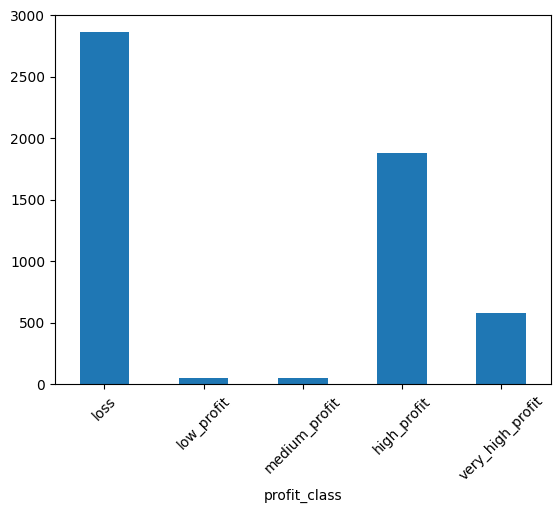

In [361]:
df_for_analyst.groupby('profit_class')['name'].count().plot.bar(rot=45)

Ekspor data final ke dalam sebuah file .csv

In [363]:
df_for_analyst.to_csv("movies_clean.csv", index=False)

##4.2 For Data Scientist

Metode encoding apa yang tepat untuk *profit_class*? One-Hot Encoding atau Label Encoding?

In [337]:
profit2class = {c:i for i,c in enumerate(df_for_datsci['profit_class'].dtype.categories.to_list())}
profit2class

{'loss': 0,
 'low_profit': 1,
 'medium_profit': 2,
 'high_profit': 3,
 'very_high_profit': 4}

In [338]:
df_for_datsci['profit_class'] = df_for_datsci['profit_class'].apply(lambda x: profit2class.get(x))
df_for_datsci.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,3
1,American Gigolo,R,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,8.618697e+05,2
2,Private Benjamin,R,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,1.147760e+07,3
3,Somewhere in Time,PG,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,-3.519721e+05,0
4,9 to 5,PG,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,1.147760e+07,3


Metode encoding apa yang tepat untuk *rating*? One-Hot Encoding atau Label Encoding?

In [339]:
rating_hierarchy = ['Approved','G','PG','PG-13','R','NC-17','X','TV-MA','Not Rated','Unrated']

rating2class = {r:i for i, r in enumerate(rating_hierarchy)}

df_for_datsci['rating'] = df_for_datsci['rating'].apply(lambda x: rating2class.get(x))
df_for_datsci.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,4,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,3
1,American Gigolo,4,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,8.618697e+05,2
2,Private Benjamin,4,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,1.147760e+07,3
3,Somewhere in Time,2,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,-3.519721e+05,0
4,9 to 5,2,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,1.147760e+07,3


Metode encoding apa yang tepat untuk *genre*? One-Hot Encoding atau Label Encoding?

In [340]:
df_for_datsci = df_for_datsci.join(pd.get_dummies(df['genre'], 'genre'))
df_for_datsci.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,Willie & Phil,4,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,...,0,0,0,0,0,0,0,0,0,0
1,American Gigolo,4,Crime,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,...,1,0,0,0,0,0,0,0,0,0
2,Private Benjamin,4,Comedy,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,...,0,0,0,0,0,0,0,0,0,0
3,Somewhere in Time,2,Drama,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,...,0,1,0,0,0,0,0,0,0,0
4,9 to 5,2,Comedy,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,...,0,0,0,0,0,0,0,0,0,0


In [341]:
columns  = list(df_for_datsci.columns)

In [342]:
genre_cols = [c for c in columns if c.startswith("genre_")]

In [343]:
new_cols = columns[:2] + genre_cols + columns[3:12]
df_for_datsci = df_for_datsci[new_cols]
df_for_datsci.head()

,name,rating,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,...,genre_Western,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,4,0,0,0,0,1,0,0,0,...,0,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,3
1,American Gigolo,4,0,0,0,0,0,1,0,0,...,0,1980,1980-02-01,6.2,Paul Schrader,4800000,5031064.25,231064.25,8.618697e+05,2
2,Private Benjamin,4,0,0,0,0,1,0,0,0,...,0,1980,1980-10-10,6.2,Howard Zieff,10000000,13077105.50,3077105.50,1.147760e+07,3
3,Somewhere in Time,2,0,0,0,0,0,0,1,0,...,0,1980,1980-10-03,7.2,Jeannot Szwarc,5100000,5005637.50,-94362.50,-3.519721e+05,0
4,9 to 5,2,0,0,0,0,1,0,0,0,...,0,1980,1980-12-19,6.9,Colin Higgins,10000000,13077105.50,3077105.50,1.147760e+07,3


Ekspor data final untuk data scientist ke sebuah .csv file

In [ ]:
df_for_analyst.to_csv("movies_clean_for_datsci.csv", index=False)